In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

with open('institutes.json', 'r') as file: jsondata = json.load(file)

institutes_list = []
for country, institutes in jsondata.items():
    for institute in institutes:
        institute['country'] = country
        institutes_list.append(institute)

df = pd.DataFrame(institutes_list)
print('Data loaded.')

Data loaded.


In [2]:
import geopandas as gpd
world = gpd.read_file('country-level-mapdata/ne_110m_admin_0_countries.shp')
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)
print('Map and geo-dataframe ready.')

Map and geo-dataframe ready.


In [3]:
gdf

,city,institute,latitude,longitude,country,geometry
0,Tirana,University of Tirana,41.3275,19.8189,Albania,POINT (19.8189 41.3275)
1,Yerevan,Yerevan Physics Institute,40.1811,44.5136,Armenia,POINT (44.5136 40.1811)
2,Yerevan,Institute for Theoretical Physics and Modelling,40.1811,44.5136,Armenia,POINT (44.5136 40.1811)
3,Vienna,Institute for High Energy Physics,48.2082,16.3738,Austria,POINT (16.3738 48.2082)
4,Sakheer,University of Bahrain,26.0524,50.5104,Bahrain,POINT (50.5104 26.0524)
...,...,...,...,...,...,...
243,Boston,Northeastern University,42.3601,-71.0589,USA,POINT (-71.0589 42.3601)
244,Piscataway,Rutgers University,40.5008,-74.4479,USA,POINT (-74.4479 40.5008)
245,Batavia,Fermi National Accelerator Laboratory,41.8419,-88.2539,USA,POINT (-88.2539 41.8419)
246,College Park,University of Maryland,38.9897,-76.9378,USA,POINT (-76.9378 38.9897)


### Simple world-map

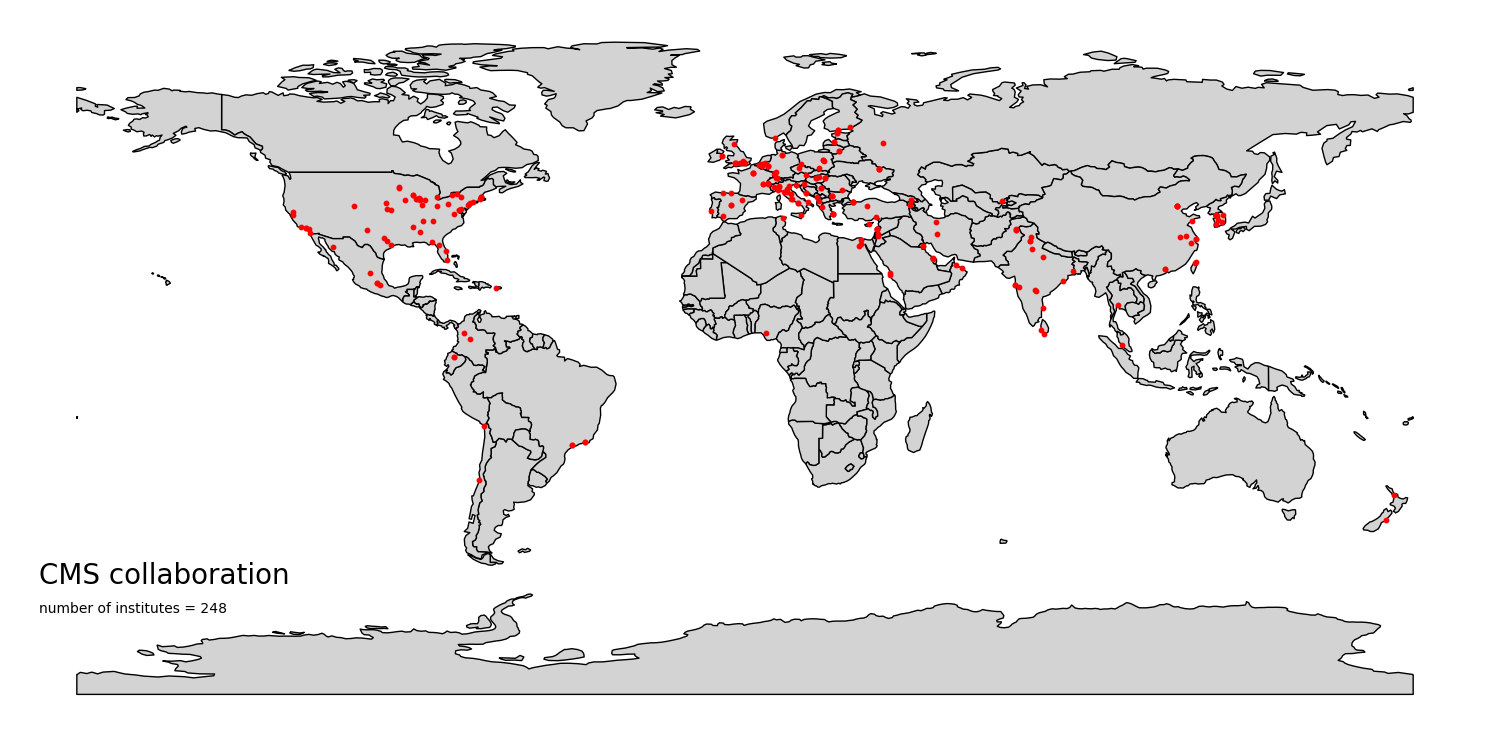

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', marker='o', markersize=10)
ax.set_axis_off()
ax.text(0.02, 0.20, 'CMS collaboration', fontsize=20, transform=ax.transAxes)
ax.text(0.02, 0.16, f'number of institutes = {len(df)}', transform=ax.transAxes)
plt.tight_layout()
plt.show()

### Interactive map

In [5]:
import folium

m = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=2
)

folium.TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
).add_to(m)

for idx, row in df.iterrows():
    html_popup = f"""
    <div style="font-size: 14px;">
        <b>{row['institute']}</b><br>
        {row['city']}, {row['country']}<br>
        <i>Latitude:</i> {row['latitude']}<br>
        <i>Longitude:</i> {row['longitude']}
    </div>
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(html_popup, max_width=300),
        tooltip=row['institute'],
        icon=folium.Icon(color='red', icon='university', prefix='fa')
    ).add_to(m)

m.save("interactive-map.html")

In [6]:
from IPython.display import IFrame
IFrame("interactive-map.html", width=700, height=500)

### Country-wise institute count

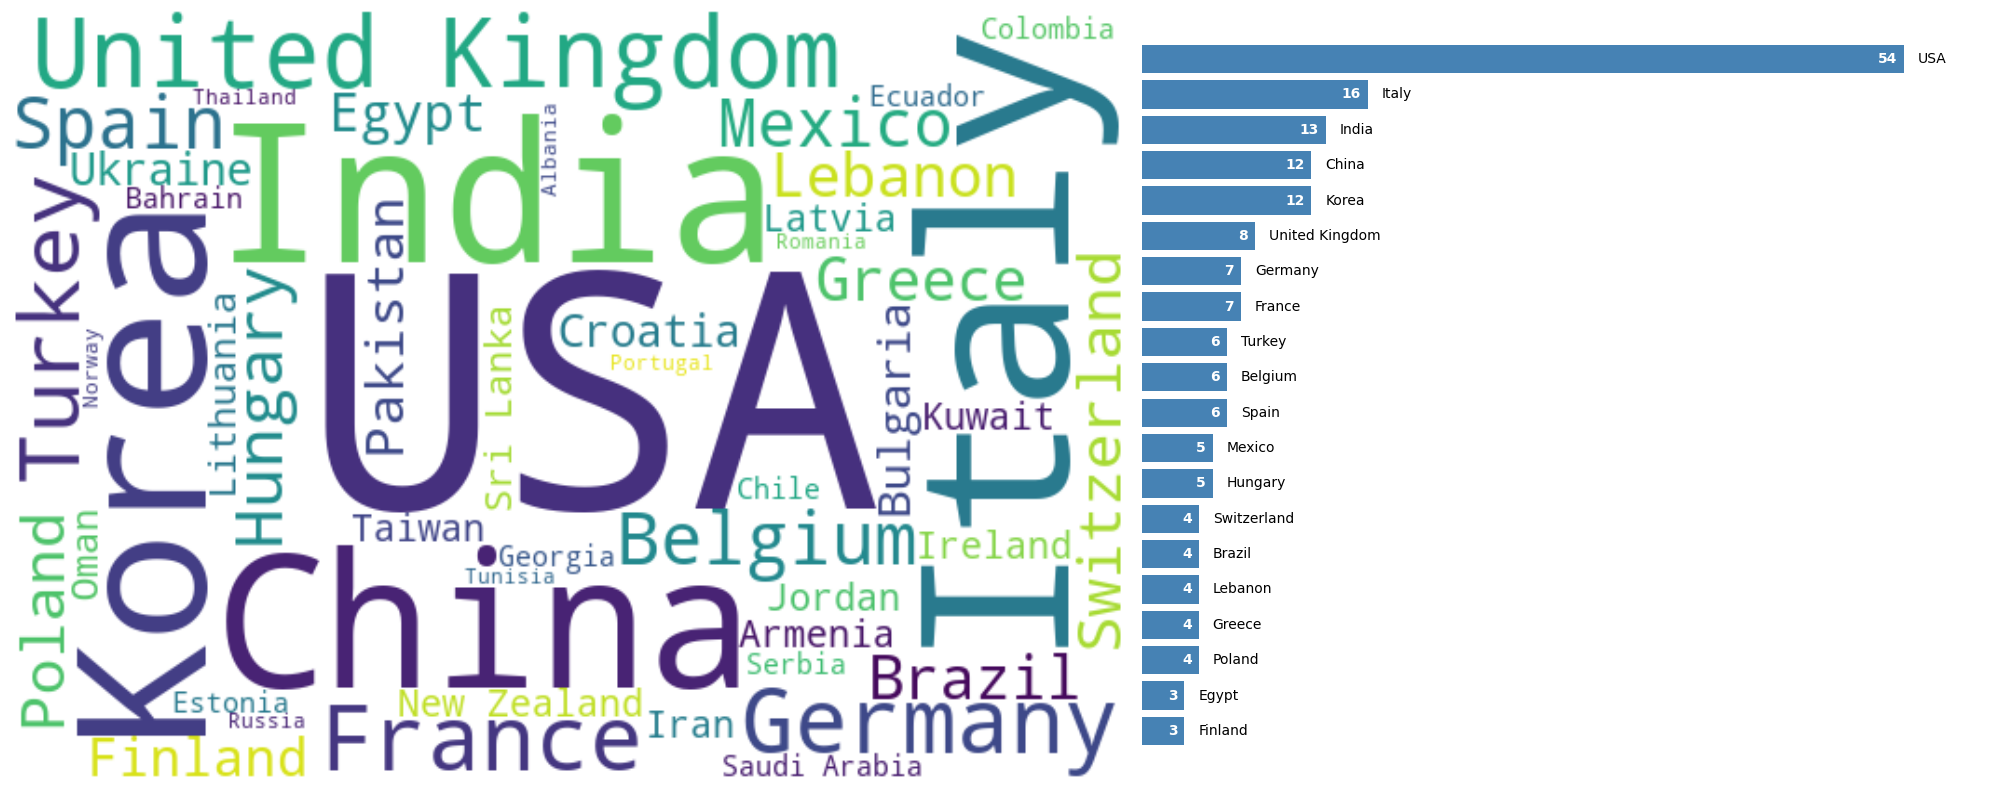

In [7]:
from wordcloud import WordCloud
country_counts = df['country'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [4, 3]})

# Word Cloud (Left Plot)
wordcloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=50
).generate_from_frequencies(country_counts)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')

# Bar Chart (Right Plot)
top_countries = country_counts.head(20)
bars = ax2.barh(top_countries.index, top_countries.values, color='steelblue', height=0.8)

# Add count labels inside bars
for bar, label in zip(bars, top_countries.index):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax2.text(width - 0.5, y, f"{int(width)}", ha='right', va='center', color='white', fontweight='bold')
    ax2.text(width + 1, y, label, ha='left', va='center', fontsize=10)

ax2.axis('off')  # Remove all axes
ax2.set_xlim(0, top_countries.max() * 1.1)  # Add some padding
ax2.invert_yaxis()

# Add CMS collaboration text at bottom right
#ax2.text(0.95, 0.2, 'CMS Collaboration', ha='right', fontsize=30, transform=ax2.transAxes)
#ax2.text(0.95, 0.15, '*Russia not included', ha='right', fontsize=10, transform=ax2.transAxes)

# Equalize the subplot sizes
ax1.set_aspect('auto')
ax2.set_aspect('auto')

plt.tight_layout()
plt.show()

### City-wise institute count

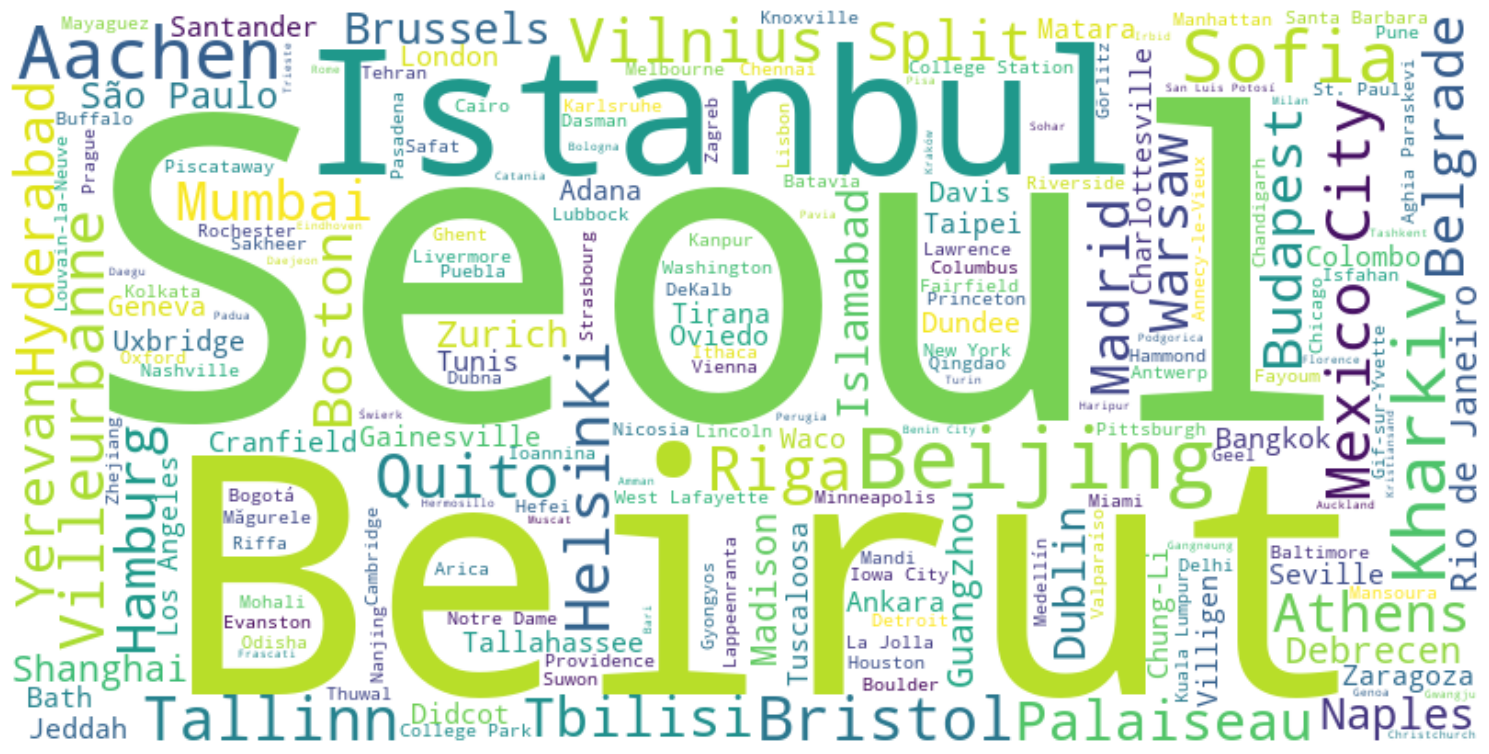

In [8]:
from wordcloud import WordCloud

city_counts = df['city'].value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(city_counts)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()